In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
all_xray_df = pd.read_csv('../data/sample_labels.csv')

In [3]:
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'data', 'images*', '*.png'))}
#print(type(all_image_paths))
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df['Patient Age'] = all_xray_df['Patient Age'].map(lambda x: int(x[:-1]))
all_xray_df.sample(3)

Scans found: 5606 , Total Headers 5606


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
951,00004948_001.png,No Finding,1,4948,18,M,PA,2048,2500,0.168000,0.168000,..\data\images\00004948_001.png
5569,00030418_000.png,No Finding,0,30418,22,M,PA,2021,2021,0.194311,0.194311,..\data\images\00030418_000.png
3132,00015442_026.png,No Finding,26,15442,61,F,PA,2536,3048,0.139000,0.139000,..\data\images\00015442_026.png


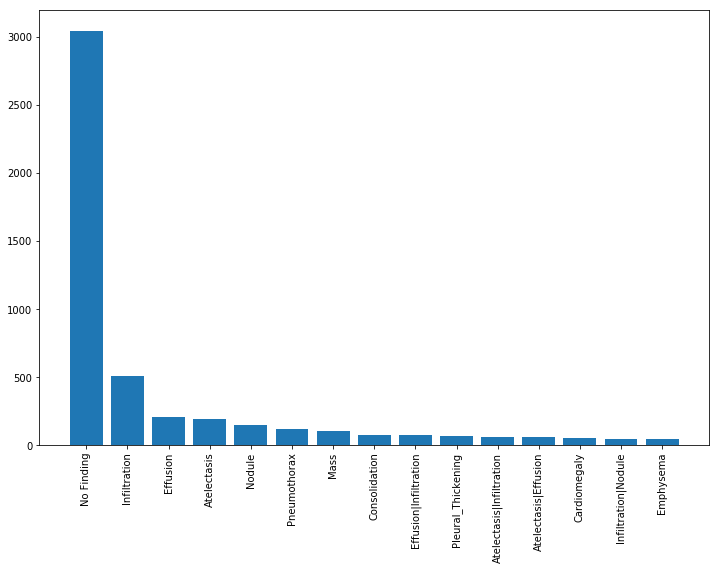

In [4]:
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [5]:
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
3910,00019271_024.png,,24,19271,54,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5050,00026818_024.png,,24,26818,31,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1321,00006942_000.png,,0,6942,51,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# keep at least 1000 cases
MIN_CASES = 50
all_labels = [c_label for c_label in all_labels if all_xray_df[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(all_xray_df[c_label].sum())) for c_label in all_labels])

Clean Labels (13) [('Atelectasis', 508), ('Cardiomegaly', 141), ('Consolidation', 226), ('Edema', 118), ('Effusion', 644), ('Emphysema', 127), ('Fibrosis', 84), ('Infiltration', 967), ('Mass', 284), ('Nodule', 313), ('Pleural_Thickening', 176), ('Pneumonia', 62), ('Pneumothorax', 271)]


In [7]:
print(all_xray_df.shape[0])

5606


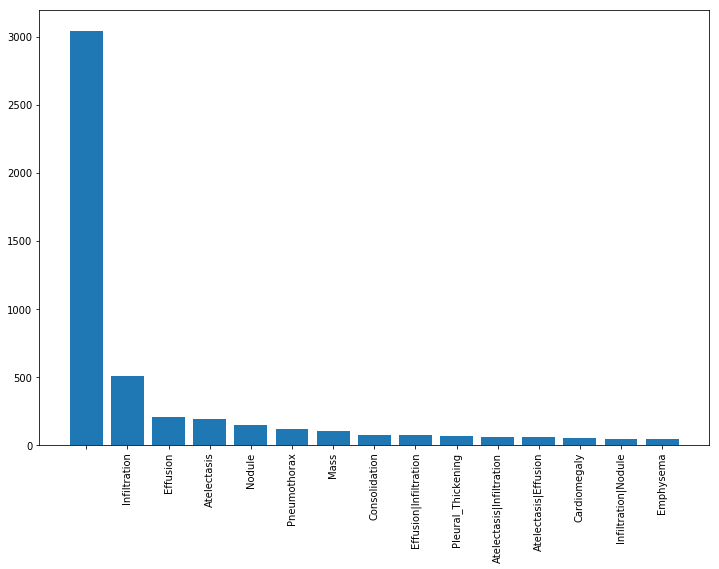

In [8]:
# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.1 + number of findings
sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
all_xray_df = all_xray_df.sample(5606, weights=sample_weights)

label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

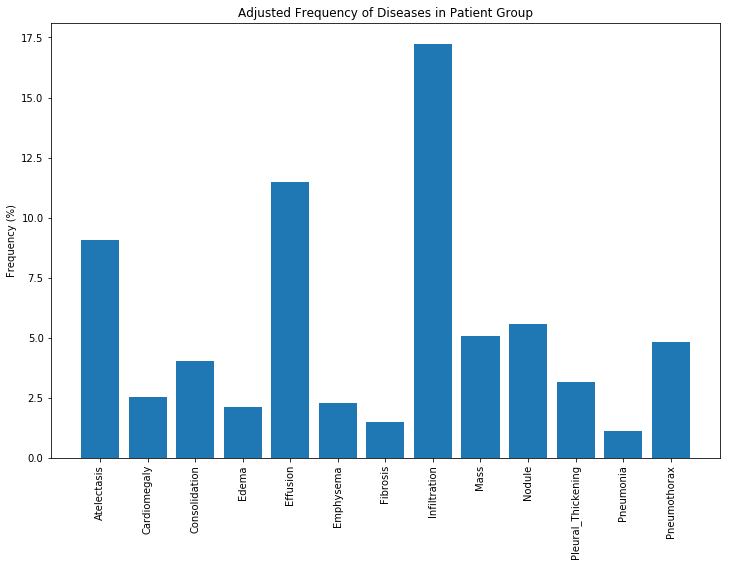

In [9]:
label_counts = 100*np.mean(all_xray_df[all_labels].values,0)
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 90)
ax1.set_title('Adjusted Frequency of Diseases in Patient Group')
_ = ax1.set_ylabel('Frequency (%)')

In [10]:
print(all_xray_df[all_labels].values[0])

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [11]:
all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [12]:
print(all_xray_df['disease_vec'])

2368    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
2696    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2312    [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
4054    [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
185     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
3718    [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2638    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
863     [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2272    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
4892    [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...
4077    [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
2201    [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
1662    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2705    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
2516    [1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, ...
4988    [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
5430    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
1814    [1.0, 

In [13]:
print(all_xray_df)

           Image Index                                     Finding Labels  \
2368  00012010_008.png                                       Infiltration   
2696  00013613_013.png                                                      
2312  00011793_004.png                               Atelectasis|Effusion   
4054  00019967_033.png                             Consolidation|Effusion   
185   00001075_003.png                            Mass|Pleural_Thickening   
3718  00018251_006.png                                              Edema   
2638  00013249_043.png                          Cardiomegaly|Infiltration   
863   00004526_007.png                                       Cardiomegaly   
2272  00011640_000.png                                Infiltration|Nodule   
4892  00025787_012.png                       Effusion|Infiltration|Nodule   
4077  00020113_014.png                               Atelectasis|Effusion   
2201  00011379_033.png           Effusion|Pleural_Thickening|Pneumothorax   

In [14]:
print(all_xray_df['disease_vec'][1])

[0.0 1.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]


In [15]:
print(all_xray_df['path'])

2368    ..\data\images\00012010_008.png
2696    ..\data\images\00013613_013.png
2312    ..\data\images\00011793_004.png
4054    ..\data\images\00019967_033.png
185     ..\data\images\00001075_003.png
3718    ..\data\images\00018251_006.png
2638    ..\data\images\00013249_043.png
863     ..\data\images\00004526_007.png
2272    ..\data\images\00011640_000.png
4892    ..\data\images\00025787_012.png
4077    ..\data\images\00020113_014.png
2201    ..\data\images\00011379_033.png
1662    ..\data\images\00008694_002.png
2705    ..\data\images\00013616_027.png
2516    ..\data\images\00012643_003.png
4988    ..\data\images\00026321_001.png
5430    ..\data\images\00029479_003.png
1814    ..\data\images\00009574_017.png
580     ..\data\images\00003011_004.png
3618    ..\data\images\00017818_001.png
4937    ..\data\images\00026024_004.png
431     ..\data\images\00002300_044.png
3289    ..\data\images\00016240_001.png
3342    ..\data\images\00016508_012.png
3206    ..\data\images\00015770_005.png


In [16]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(all_xray_df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 4204 validation 1402


In [17]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (128, 128)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

D:\work\envs\tensorflow\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


In [18]:
print(valid_df['disease_vec'].values)

[array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
      dtype=object)
 array([0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
      dtype=object)
 array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
      dtype=object)
 ...
 array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
      dtype=object)
 array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
      dtype=object)
 array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
      dtype=object)]


In [19]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print(base_dir)
    print(in_df[path_col])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [20]:
train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 32)


..\data\images
4597    ..\data\images\00022947_001.png
2760    ..\data\images\00013832_000.png
1271    ..\data\images\00006691_000.png
2332    ..\data\images\00011845_008.png
3110    ..\data\images\00015355_000.png
1255    ..\data\images\00006626_005.png
2017    ..\data\images\00010509_004.png
2702    ..\data\images\00013615_043.png
378     ..\data\images\00001989_002.png
4172    ..\data\images\00020471_006.png
1106    ..\data\images\00005759_007.png
2288    ..\data\images\00011702_070.png
3202    ..\data\images\00015732_038.png
1961    ..\data\images\00010284_000.png
4326    ..\data\images\00021307_003.png
316     ..\data\images\00001684_025.png
4876    ..\data\images\00025642_000.png
4528    ..\data\images\00022596_008.png
5253    ..\data\images\00028207_001.png
1918    ..\data\images\00010007_164.png
5282    ..\data\images\00028433_006.png
487     ..\data\images\00002537_002.png
1718    ..\data\images\00009006_000.png
4414    ..\data\images\00021835_001.png
912     ..\data\images\00

In [21]:
print(train_gen.n)

4204


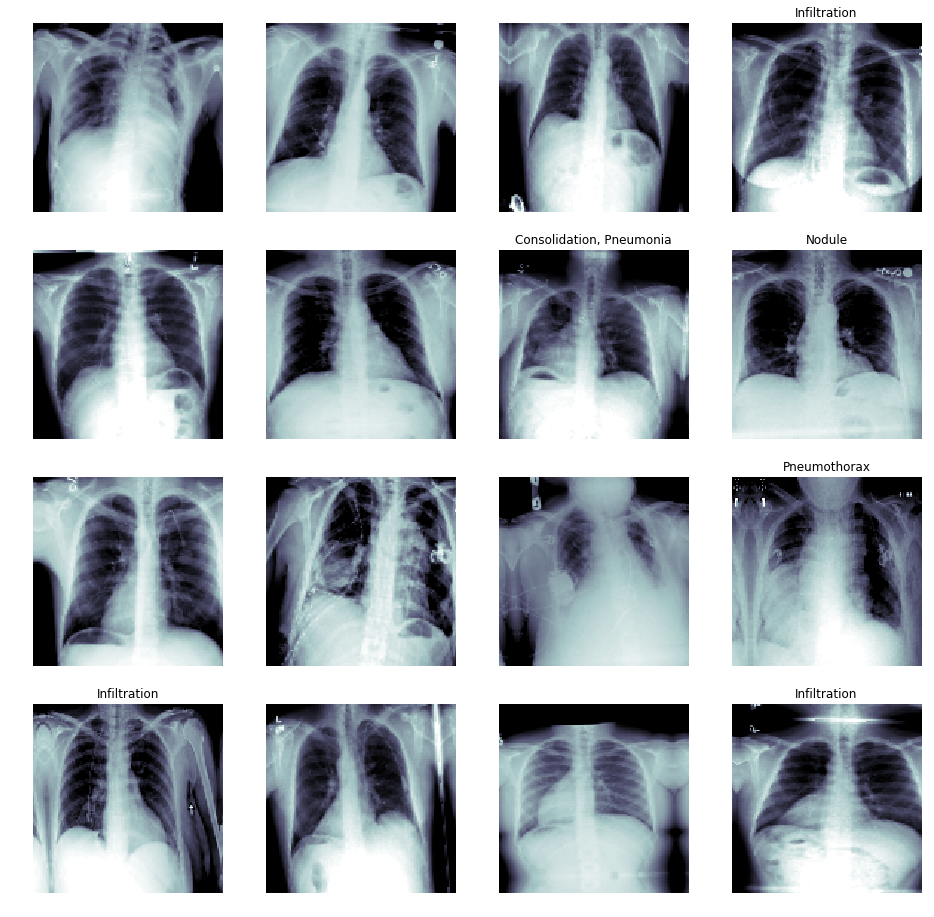

In [22]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

In [23]:
valid_gen = flow_from_dataframe(core_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 256) # we can use much larger batches for evaluation
# used a fixed dataset for evaluating the algorithm
test_X, test_Y = next(flow_from_dataframe(core_idg, 
                               valid_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 1024)) # one big batch

..\data\images
2592    ..\data\images\00013003_041.png
2375    ..\data\images\00012021_037.png
2745    ..\data\images\00013750_026.png
1171    ..\data\images\00006215_000.png
3399    ..\data\images\00016778_017.png
2396    ..\data\images\00012087_042.png
2080    ..\data\images\00010767_008.png
4831    ..\data\images\00025391_004.png
3456    ..\data\images\00017049_011.png
5010    ..\data\images\00026480_004.png
231     ..\data\images\00001256_007.png
2774    ..\data\images\00013890_013.png
1484    ..\data\images\00007729_000.png
1127    ..\data\images\00005895_024.png
3096    ..\data\images\00015239_006.png
4109    ..\data\images\00020240_000.png
1896    ..\data\images\00009938_003.png
3538    ..\data\images\00017504_014.png
5382    ..\data\images\00029043_002.png
4989    ..\data\images\00026333_000.png
5518    ..\data\images\00030079_049.png
1043    ..\data\images\00005448_019.png
1795    ..\data\images\00009473_001.png
408     ..\data\images\00002122_002.png
2235    ..\data\images\00

In [24]:
print(len(valid_df))

1402


In [25]:
print(valid_gen.classes[0])

[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]


In [26]:
print(valid_gen.samples)

1402


In [27]:
print(test_X[1].shape)

(128, 128, 1)


In [28]:
print(test_X)

[[[[-2.8296297 ]
   [-2.774818  ]
   [-2.7110064 ]
   ...
   [-3.623961  ]
   [-3.6287487 ]
   [-3.6509724 ]]

  [[-3.0317729 ]
   [-2.9585152 ]
   [-2.892265  ]
   ...
   [-3.6176481 ]
   [-3.6224358 ]
   [-3.6432319 ]]

  [[-3.051041  ]
   [-3.0075133 ]
   [-2.9449918 ]
   ...
   [-3.684337  ]
   [-3.6857045 ]
   [-3.690655  ]]

  ...

  [[ 1.0282159 ]
   [ 1.0578436 ]
   [ 1.116218  ]
   ...
   [ 0.39136767]
   [ 0.46919465]
   [ 0.55933875]]

  [[ 1.054541  ]
   [ 1.076292  ]
   [ 1.1051363 ]
   ...
   [ 0.4080724 ]
   [ 0.49154064]
   [ 0.59544903]]

  [[ 1.07638   ]
   [ 1.0971993 ]
   [ 1.1184995 ]
   ...
   [ 0.39802593]
   [ 0.49040344]
   [ 0.6033711 ]]]


 [[[-1.5165111 ]
   [-1.5619366 ]
   [-1.6141797 ]
   ...
   [-1.7198488 ]
   [-1.7360412 ]
   [-1.7360412 ]]

  [[-1.4477775 ]
   [-1.476976  ]
   [-1.5230546 ]
   ...
   [-1.7360412 ]
   [-1.7360412 ]
   [-1.7360412 ]]

  [[-1.3710405 ]
   [-1.4066834 ]
   [-1.4495655 ]
   ...
   [-1.7360412 ]
   [-1.7360412 ]
   [-1.7360

In [29]:
print(test_Y[1])

[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0]


In [30]:
print(valid_gen.filenames[0])

..\data\images\00013003_041.png


In [31]:
print(valid_gen.classes[0])

[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]


In [32]:
print(list(all_xray_df['Image Index']))

['00012010_008.png', '00013613_013.png', '00011793_004.png', '00019967_033.png', '00001075_003.png', '00018251_006.png', '00013249_043.png', '00004526_007.png', '00011640_000.png', '00025787_012.png', '00020113_014.png', '00011379_033.png', '00008694_002.png', '00013616_027.png', '00012643_003.png', '00026321_001.png', '00029479_003.png', '00009574_017.png', '00003011_004.png', '00017818_001.png', '00026024_004.png', '00002300_044.png', '00016240_001.png', '00016508_012.png', '00015770_005.png', '00019089_010.png', '00011770_004.png', '00025610_000.png', '00000459_037.png', '00004858_058.png', '00006372_005.png', '00007500_001.png', '00010092_051.png', '00004843_004.png', '00029597_007.png', '00012298_011.png', '00023078_007.png', '00030176_000.png', '00026451_027.png', '00005982_002.png', '00019464_004.png', '00016142_010.png', '00028208_004.png', '00019938_003.png', '00028324_001.png', '00022947_001.png', '00016784_002.png', '00026132_026.png', '00008944_003.png', '00002491_007.png',

In [138]:
print(list(all_xray_df['Image Index']).index('00000061_025.png'))

674


In [139]:
print(list(all_xray_df['Finding Labels'])[674])

Consolidation|Effusion|Infiltration|Nodule


In [35]:
print(list(all_xray_df['Image Index']).index('00013917_056.png'))

2633


In [36]:
print(list(all_xray_df['Finding Labels'])[3178])

In [37]:
print(list(all_xray_df['Image Index']).index('00024885_000.png'))

1835


In [38]:
print(list(all_xray_df['Finding Labels'])[3664])

In [39]:
print(list(all_xray_df['Image Index']).index('00004048_012.png'))

2660


In [40]:
print(list(all_xray_df['Finding Labels'])[1068])

Atelectasis


In [41]:
print(t_x.shape[1:])

(128, 128, 1)


In [42]:
print(len(all_labels))

13


In [56]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
base_mobilenet_model = MobileNet(input_shape =  t_x.shape[1:], 
                                 include_top = False, weights = None)
multi_disease_model = Sequential()
multi_disease_model.add(base_mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(all_labels), activation = 'sigmoid'))

In [57]:
multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
multi_disease_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Model)   (None, 4, 4, 1024)        3228288   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 13)                6669      
Total params: 3,759,757
Trainable params: 3,737,869
Non-trainable params: 21,888
_____________________________________________________________

In [58]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights5606.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

In [55]:
multi_disease_model.fit_generator(train_gen, 
                                  steps_per_epoch=100,
                                  validation_data = (test_X, test_Y), 
                                  epochs = 5, 
                                  callbacks = callbacks_list)

Epoch 1/5


KeyboardInterrupt: 

In [59]:
import json
model_json = multi_disease_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(json.dumps(json.loads(model_json), indent=4))

In [60]:
multi_disease_model.load_weights('xray_class_weights.best.hdf5')

In [140]:
import cv2
img = cv2.imread('uploads/to show/00000061_025.png')
print("original_img: ", img.shape) 
img = cv2.resize(img, (128,128))
# if img.shape[2] ==1:
#              img = np.dstack([img, img, img])
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print("grayscale_image: ", img.shape)
img = img[:, :, np.newaxis]
print("new_grayscale_image: ", img.shape)
img = img.astype(np.float32)/255.
img=np.expand_dims( img,axis=0 )
print(img.shape)

original_img:  (1024, 1024, 3)
grayscale_image:  (128, 128)
new_grayscale_image:  (128, 128, 1)
(1, 128, 128, 1)


In [141]:
pred_Y = multi_disease_model.predict(img, verbose = True)

1/1 [==============================] - 1s 716ms/step


In [142]:
print(pred_Y)

[[0.32365352 0.04020599 0.22841056 0.14184184 0.33253223 0.01982711
  0.02109993 0.5740649  0.09805345 0.05821263 0.04746476 0.05862358
  0.05554091]]


In [51]:
from keras.utils import plot_model
plot_model(multi_disease_model, to_file='model.png')

OSError: `pydot` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.

In [64]:
print(multi_disease_model.History.history.keys())

AttributeError: 'Sequential' object has no attribute 'History'